# The Mesh


The finite element mesh is a fundamental construct for Underworld modelling. It will generally determine your domain geometry, and the resolution of the finite element system. For parallel simulations, the mesh topology will also determine the domain decomposition for the problem. Currently `underworld` only provides curvilinear mesh capabilities.

#### Overview:

1. Creating mesh objects.
1. Element types.
1. Deforming the mesh.
1. Loading and saving the mesh.
1. Special sets.
1. Mesh variables
1. Setting values on a mesh variables.
1. Gradients of mesh variable fields.
1. Loading and saving mesh variable data.

**Keywords:** mesh variables, finite elements, load, save, initial conditions

## Creating the mesh

First create an 2x2 element mesh. By default the mesh will be of rectangular geometry, with domain extents specified via the `minCoord` and `maxCoord` constructor parameters. 


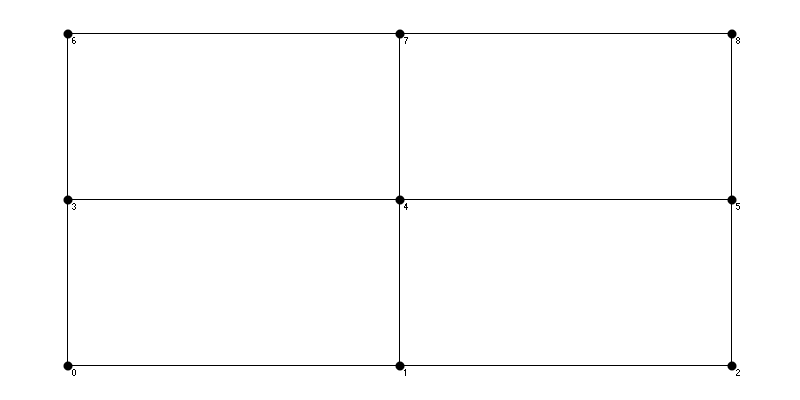

In [1]:
# This example creates a mesh, and visualises it. 
import underworld as uw
import glucifer
mesh = uw.mesh.FeMesh_Cartesian( elementRes  = (2, 2), 
                                 minCoord    = (0.0, 0.0), 
                                 maxCoord    = (2.0, 1.0) )

# visualising the result
figMesh = glucifer.Figure(figsize=(800,400))
figMesh.append( glucifer.objects.Mesh(mesh, nodeNumbers=True, pointsize=10) )
figMesh.show()

As is usually the pattern for data carrying objects in Underworld, underlying data is available as `numpy` arrays via the `data` mesh instances attribute. In the case of mesh objects, this data corresponds to mesh node coordinate information.

In [2]:
# This example simply prints mesh node information.
import underworld as uw
mesh = uw.mesh.FeMesh_Cartesian(elementRes=(2, 2))
for item in mesh.data:
    print(item)

[ 0.  0.]
[ 0.5  0. ]
[ 1.  0.]
[ 0.   0.5]
[ 0.5  0.5]
[ 1.   0.5]
[ 0.  1.]
[ 0.5  1. ]
[ 1.  1.]


Note that data in `underworld` is always published as arrays of shape `(num_items, count)`, where `num_items` is the number of items in the dataset (in this case, 3x3 nodes, so `9`), and `count` is the size of each data item (so `1` for scalar data, `2` or `3` for vectors in 2- and 3-dimensions respectively, etc). 

In parallel, each process will be assigned responsibility for a subsection of the domain, and as such the length (`num_items`) of the arrays will generally be different across processes. As such, while it might be tempting to use `numpy.reshape` to reshape your arrays to reflect the cartesian mesh topology, this approach will **not** work in parallel and is therefore not usually recommended. You should instead traverse data arrays as 1-d lists (each item of size `count`). Following this pattern will usually result in models which can safely be run in serial or parallel. 

## Element Types
Underworld supports two primary element types: a linear element type (`Q1`) and a quadratic element type (`Q2`). Interpolation using these element types will provide continuous results across element boundaries, though note that interpolant derivatives will be discontinous across boundaries. Underworld also supports *mixed* element types, where a secondary element type may also be specified. This formulation is critical for stable solutions to Stokes type problems, with velocity fields being represented by the primary element type, and pressure fields by the secondary type. Secondary element types are not continuous across element boundaries. Supported secondary types are constant (`dQ0`), linear (`dPc1`) and bilinear (`dQ1`). Refer to http://femtable.org for further details on element types. 

Mesh element types are specified as a textual argument to the `elementType` constructor parameter. A primary type must always be provided (`Q1` or `Q2`), and where a secondary type is required, the primary/secondary types are provided as a pair (`Q1/dQ0`, `Q2/dPc1` or `Q2/dQ1`). For mixed type elements, two mesh objects are generated by the constructor, one for the primary and one for the secondary elements. The primary mesh will be the object returned directly by the constructor, with the secondary mesh available via the primary mesh's `subMesh` attribute.

Note that where constructor parameters are omitted, default values are used. Defaults values are baked into the `underworld` API and may be determined in Jupyter by pressing `shift`-`tab` with the cursor inside the constructor parenthesis, or by using the Python `help()` function (with the class/function of interest as the argument). Default values are useful for quickly mocking up models, but may change without notice so should not be relied upon. 

Element boundaries (and therefore domain geometry and resolution) is entirely determined by the primary mesh, with the location of the secondary mesh nodes slaved to the primary mesh nodes. Secondary mesh nodes are visualised below.


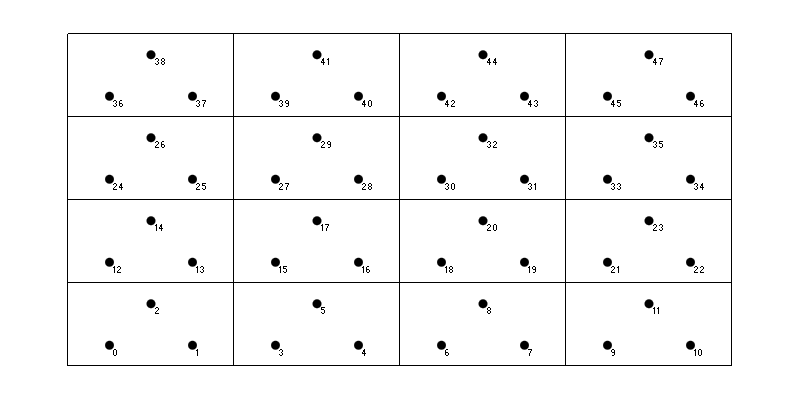

In [3]:
# Create a mesh with submesh
import underworld as uw
import glucifer
mesh = uw.mesh.FeMesh_Cartesian( elementType="Q2/dpc1", maxCoord=(2.0, 1.0) )
submesh = mesh.subMesh
figMesh = glucifer.Figure(figsize=(800,400))
figMesh.append( glucifer.objects.Mesh(mesh) )
figMesh.append( glucifer.objects.Mesh(submesh, nodeNumbers=True, pointsize=10) )
figMesh.show()

## Deforming the mesh

It is often desirable to deform the mesh to either conform the domain to some geometry, or to implement mesh refinement by bunching nodes in certain domain regions. The user is free to modify the mesh as desired, though care must be taken to ensure elements are not improperly transformed (Jacobians should not become singular) and to avoid tangling (face normals should be consistent). 

To deform the mesh, the user will directly modify the node coordinates via the usual `data` array. Note however that modifications are only possible from within the `deform_mesh()` context manager, as otherwise the array is read-only.


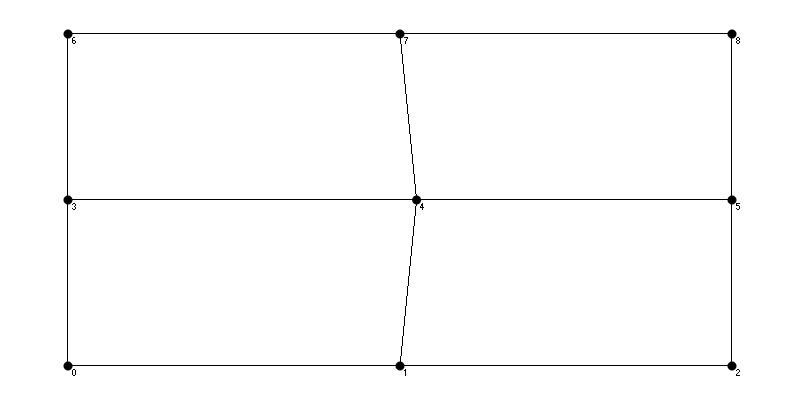

In [4]:
# A trivial deformation
import underworld as uw
import glucifer
mesh = uw.mesh.FeMesh_Cartesian(elementRes=(2, 2), maxCoord=(2.0, 1.0) )
with mesh.deform_mesh():
    mesh.data[4][0] += 0.05
figMesh = glucifer.Figure(figsize=(800,400))
figMesh.append( glucifer.objects.Mesh(mesh, nodeNumbers=True, pointsize=10) )
figMesh.show()

Note that in the above example, for simplicity, we've simply moved an arbitrary mesh node. Usually you will not want to construct your logic in ways which rely on the node numbers themselves, as this will usually not be consistent across parallel simulations, and/or as you vary model resolution.

We now look at a more realistic example where we deform the mesh to increase the resolution at the top of the domain. There are countless ways this may be achieved, but here we use the simple transformation $z \rightarrow \sqrt{z}$:


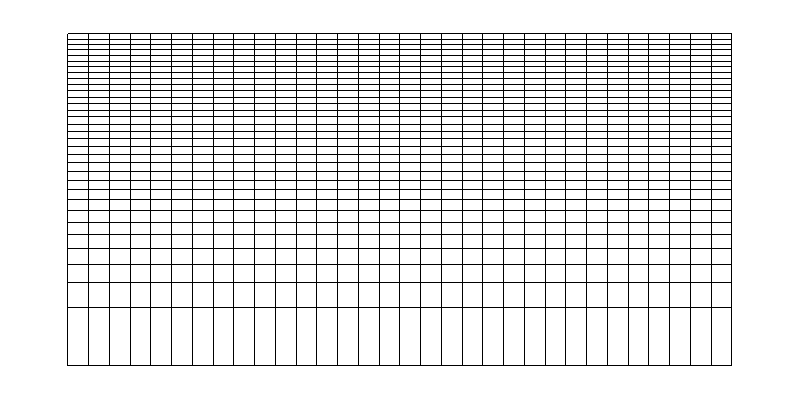

In [5]:
# A more useful deformation
import underworld as uw
import glucifer
mesh = uw.mesh.FeMesh_Cartesian(elementRes=(32,32), maxCoord=(2.0, 1.0))
with mesh.deform_mesh():
    for index, coord in enumerate(mesh.data):
        mesh.data[index][1] = mesh.data[index][1]**0.5
figMesh = glucifer.Figure(figsize=(800,400))
figMesh.append(glucifer.objects.Mesh(mesh))
figMesh.show()

## Saving and loading the mesh


Your mesh data may be loaded or saved using the mesh instance `load()` and `save()` method respectively. All data in Underworld is written as HDF5 format binary files. There are numerous tools available for interrogating HDF5 files, but in Underworld we primarily leverage the `h5py` Python package. We recommend that users also familiarise themselves with this package to allow querying of Underworld generated data, and also as an excellent option for directly writing their own simulation data. 

You will wish to save data for analysis purposes, but also for simulation restart.  Note that Underworld does not provide any explicit *restart* functionality, and you will instead need to use object `load()` methods to return each object to their previous states. In Underworld, the pattern is always to first *recreate* vanilla equivalent objects, and *then* reload the data. So in the case of the mesh above, you must first recreate a standard mesh object, and it must be of identical resolution and element type. Finally you will reload the data.

In [6]:
# In this example we'll walk through some of the mesh loading mechanisms
import underworld as uw
mesh = uw.mesh.FeMesh_Cartesian()
# trivially deform
with mesh.deform_mesh():
    mesh.data[3]+=0.1
# save
mesh.save('deformedMesh.h5')

# create second mesh
mesh2 = uw.mesh.FeMesh_Cartesian()
# confirm that it is different to first
import numpy as np
result = np.allclose(mesh.data,mesh2.data)
if result==True:  # raise error if result not as expected
    raise RuntimeError("Mesh objects should not match. Something wrong has happenend")

# now load data onto second mesh, and re-test
mesh2.load('deformedMesh.h5')
result = np.allclose(mesh.data,mesh2.data)
if result==False:  # raise error if result not as expected
    raise RuntimeError("Mesh objects should match. Something wrong has happenend")

# let's remove the saved file as it is no longer required. 
if uw.rank()==0:
    import os;
    os.remove('deformedMesh.h5')

<br>

## Special sets


Special sets are sets of nodes which are in some way special to a given mesh object. For instance, for the cartesian mesh you will often wish to tie special values to the walls to form your problem boundary conditions. The list of special sets is provided via the `specialSets` list object. The sets are named with respect to the `(I,J,K)` cartesian indexing of the mesh, with the `I` index usually used for the horizontal (left/right), `J` for the vertical, and `K` for horizontal (front/back). Note that this is just a matter of convention, and you are free to chose how the cartesian coordinates map within your model. So, for example,  `MinI_VertexSet` specifies the set of nodes belonings to what we would normally consider to be the left wall, and similarly `MaxI_VertexSet` the right wall.  We also provide the alias (`Left_VertexSet`, `Right_VertexSet`, etc) for the most common use case.

In [7]:
import underworld as uw
mesh = uw.mesh.FeMesh_Cartesian(elementRes=(2,2))
print("Available special sets for this mesh are:")
print(mesh.specialSets.keys())
leftset = mesh.specialSets['MinI_VertexSet']
print("\nIndices in the left set wall set:")
print(leftset)

Available special sets for this mesh are:
['MaxI_VertexSet', 'Top_VertexSet', 'Left_VertexSet', 'MinI_VertexSet', 'AllWalls_VertexSet', 'Bottom_VertexSet', 'Right_VertexSet', 'MinJ_VertexSet', 'MaxJ_VertexSet', 'Empty']

Indices in the left set wall set:
FeMesh_IndexSet([0, 3, 6])


You can confirm that these are indeed the left nodes with reference to the mesh visualisation at the top of the page. Note that the special set indices always specify parallel **local** indices. In almost all instances, you will interact with only local data and identifiers. This pattern is critical to successful parallel operation, and is usually a natural way of constructing your models. You should also note that the above visualisation shows the global node numbering, though for these serial demonstrations the values are identical. Your checkpointed mesh (and mesh variable) data will however be ordered according to its global numbering. If for some reason you need to determine the global identifiers, they are stored in the `data_elgId` array.

## Mesh Variables


Mesh variables are used to encode spatial data across the mesh. Underworld mesh variables assign data for each node of the mesh, so for example you might assign a temperature value at each mesh node. Mesh variables also leverage the mesh element shape functions to form interpolations within elements, allowing our discrete datasets to have continuous analogues formed. 

Mesh variables may be used for any number of purposes when constructing models, but most importantly they form the unknowns for the finite element numerical systems you will be solving. 

We create a mesh variable by using the mesh's `add_variable()` method, and specifying the `nodeDofCount` (node degree of freedom count). So for example, setting `nodeDofCount=1` yields a scalar mesh variable, having a single data value recorded at each node of the mesh, as you may require for perhaps a temperature field.

## Setting values on the MeshVariable

As you will find with most Underworld data carrying objects, you will access the data directly via the `data` attribute. Our data is stored there as a numpy array, and you may therefore accessed or modified it using standard Numpy operations.

Let's initialise a variable with a function based on its spatial coordinates

$$
T = 100\exp(1-z)
$$

This variable may be used to represent a temperature field. We will walk over the mesh vertex data to access coordinate information. As the temperature field array is (by design) a 1-1 map to the vertex array, we know the index of the mesh vertex will be the index of the associated temperature datum. Note that the Python *built-in* `enumerate()` acts to return **both** the index of a piece of data in a list (or array), and the data itself. 


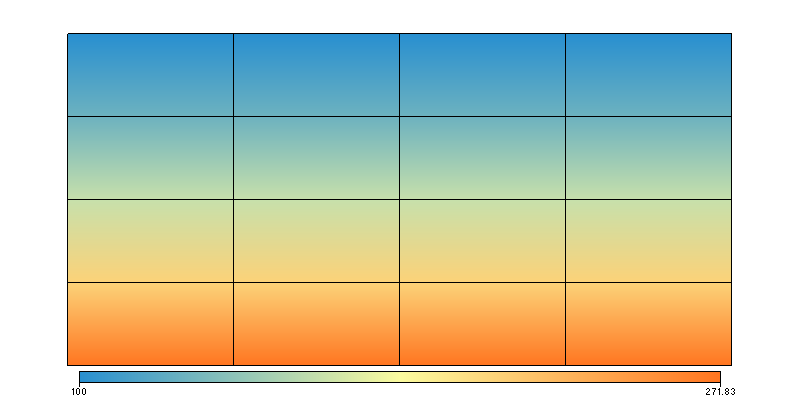

In [8]:
# create a mesh & meshvariable, and then initialise with data.
import underworld as uw
import glucifer
import math
mesh = uw.mesh.FeMesh_Cartesian( maxCoord=(2., 1.) )
# now create our mesh variable
temperatureField = mesh.add_variable( nodeDofCount=1 )

pi = math.pi
for index, coord in enumerate(mesh.data):
    temperatureField.data[index] = 100.*math.exp(1.-coord[1])

# vis results    
fig = glucifer.Figure(figsize=(800,400))
fig.append( glucifer.objects.Surface(mesh, temperatureField) )
fig.append( glucifer.objects.Mesh(mesh) )
fig.show()

To describe for example a velocity, a vector mesh variable is required. We set `nodeDofCount=2` accordingly, and initialise to:

$$
    \mathbf{v} = \left( z_0 - z, x - x_0 \right)
$$


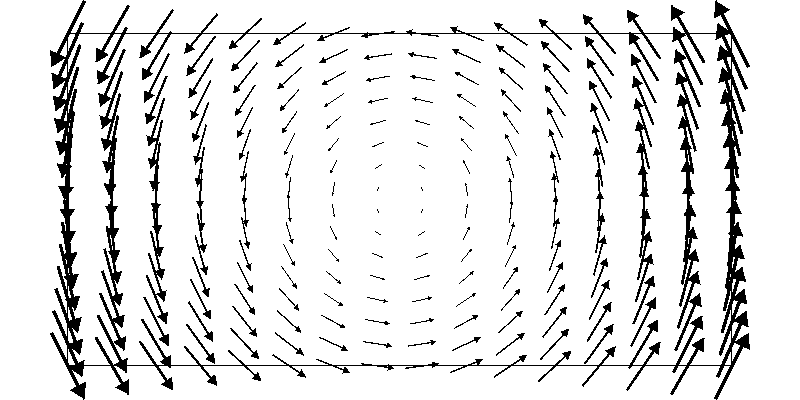

In [9]:
# vector fields
import underworld as uw
import glucifer
import math

mesh = uw.mesh.FeMesh_Cartesian( maxCoord=(2., 1.) )
velocityField = mesh.add_variable( nodeDofCount=2 )

coordmid = (1., 0.5)
for index, coord in enumerate(mesh.data):
    vx = coordmid[1] - coord[1]
    vz = coord[0]    - coordmid[0]
    velocityField.data[index] = (vx, vz)

# visualise both the velocity and temperature
fig = glucifer.Figure(figsize=(800,400))
fig.append( glucifer.objects.VectorArrows(mesh, velocityField, scaling=0.2, arrowHead=0.2) )
fig.show()

## Mesh variables gradients

Mesh variable gradients are calculated according to:

$$
    \nabla A(\mathbf{r}) = A_i\nabla\Phi_i(\mathbf{r})
$$

Note that gradients derived in this way are not generally continuous across element boundaries. Note that we access the different gradient components via the square bracket operator, with ordering:

$$
[ \frac{\partial T}{\partial x}, \frac{\partial T}{\partial y}, \frac{\partial T}{\partial z} ]
$$

or for a vector field:

$$
    [ \frac{\partial v_x}{\partial x}, \frac{\partial v_x}{\partial y}, \frac{\partial v_x}{\partial z},
      \frac{\partial v_y}{\partial x}, \frac{\partial v_y}{\partial y}, \frac{\partial v_y}{\partial z},
      \frac{\partial v_z}{\partial x}, \frac{\partial v_z}{\partial y}, \frac{\partial v_z}{\partial z} ]
$$


The gradient of the field is accessible via the ``fn_gradient`` attribute on the mesh variable.



## Loading and saving variables

The procedure for loading and saving variables is very similar to that used for the mesh, and uses the usual  `save()` and `load()` methods. For model restarts, the normal pattern applies, with the user required to generate unmodified objects first, and then reloading the required data. 

In [10]:
# mesh variable loading & saving
import underworld as uw
import numpy as np
mesh = uw.mesh.FeMesh_Cartesian()
meshvariable = mesh.add_variable(1)

# this might be a pattern you use in your models.
# set `restart` to required value, but note that
# you *must* first run with `True` to ensure that 
# a file has been created!
restart=False
restartFile = "meshvariable.h5"
if not restart:
    # not restarting, so init as required.
    meshvariable.data[:] = 1.234
else:
    meshvariable.load(restartFile)
    
# confirm that data is correct at this point! 
result = np.allclose(meshvariable.data,1.234)
if result==False:  # raise error if result not as expected
    raise RuntimeError("Mesh variable does not contain expected values.")

# now save.  generally this will occur after
# you've done something interesting, but we 
# don't have time for that in this example.
ignore = meshvariable.save(restartFile)

# let's remove the saved file as it is no longer required. 
if uw.rank()==0:
    import os;
    os.remove(restartFile)